# Моделирование восстановления золота из руды

**Описание проекта**

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План работы:

1. Загрузите и подготовьте данные.
2. Исследуйте баланс классов, обучите модель без учёта дисбаланса.
3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую.
4. Проведите финальное тестирование.

**Описание данных**

Данные находятся в трёх файлах:

1. `gold_industry_train.csv` — обучающая выборка;
2. `gold_industry_test.csv` — тестовая выборка;
3. `gold_industry_full.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Признаки технологического процесса:

1. `Rougher feed` — исходное сырье
2. `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant
3. `Xanthate` — ксантогенат (промотер, или активатор флотации);
4. `Sulphate` — сульфат (на данном производстве сульфид натрия);
5. `Depressant` — депрессант (силикат натрия).
6. `Rougher process` (англ. «грубый процесс») — флотация
7. `Rougher tails` — отвальные хвосты
8. `Float banks` — флотационная установка
9. `Cleaner process` — очистка
10. `Rougher Au` — черновой концентрат золота
11. `Final Au` — финальный концентрат золота

Параметры этапов:

1. `air amount` — объём воздуха
2. `fluid levels` — уровень жидкости
3. `feed size` — размер гранул сырья
4. `feed rate` — скорость подачи

Наименование признаков по формуле [этап].[тип_параметра].[название_параметра] (`rougher.input.feed_ag`):

Возможные значения для блока [этап]:

1. `rougher` — флотация
2. `primary_cleaner` — первичная очистка
3. `secondary_cleaner` — вторичная очистка
4. `final` — финальные характеристики

Возможные значения для блока [тип_параметра]:

1. `input` — параметры сырья
2. `output` — параметры продукта
3. `state` — параметры, характеризующие текущее состояние этапа
4. `calculation` — расчётные характеристики

In [1]:
import pandas as pd
import optuna
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots

from collections import defaultdict
from ydata_profiling import ProfileReport
from IPython.display import display

from fast_ml import eda

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, auc, roc_curve, roc_auc_score
)

In [2]:
FIG_WIDTH = 10 * 100
FIG_HEIGHT = 5 * 100
RANDOM_SEED = 42
FILE_NAMES = ['train', 'test', 'full']

In [3]:
dct_splits = {}
for file_name in FILE_NAMES:
    try:
        dct_splits[file_name] = pd.read_csv(f"gold_industry_{file_name}.csv")
    except:
        dct_splits[file_name] = pd.read_csv(f"/datasets/gold_industry_{file_name}.csv")

## Исследовательский анализ данных

### Предварительный анализ

Изучим основные зависимости в данных перед тем, как мы будем использовать их в алгоритмах машинного обучения.

Таблицы-резюме:

In [4]:
for file_name in FILE_NAMES:
    display(eda.df_info(dct_splits[file_name]).T)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
data_type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
data_type_grp,Categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,...,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical
num_unique_values,14579,14556,14556,14480,14469,14572,14475,14548,14572,14579,...,12924,14454,14453,14436,14259,14399,14493,14492,14418,14488
sample_unique_values,"[2016-01-15 00:00:00, 2016-01-15 01:00:00, 201...","[6.486149787902832, 6.478582788213898, 6.36222...","[6.100378036499023, 6.161113482574631, 6.11645...","[2.284912109375, 2.2660326347086164, 2.1596216...","[36.80859375, 35.75338486777412, 35.9716300688...","[523.5463256835939, 525.2905808989349, 530.026...","[55.48659896850586, 57.27866585926272, 57.5106...","[11.986616134643556, 11.971193238925991, 11.92...","[6.0079898834228525, 6.0057659128685765, 6.197...","[999.7069091796876, 1000.2863976666648, 999.71...",...,"[8.7646484375, 9.001494288444519, 8.8428957629...","[42.19202041625977, 42.701629246897184, 42.657...","[6.055402755737305, 6.0293685698980095, 6.0559...","[9.8896484375, 9.968944097095063, 10.213994565...","[5.50732421875, 5.257781484127045, 5.383758768...","[70.54121591421571, 69.26619763433304, 68.1164...","[2.143149375915528, 2.2249303504399105, 2.2578...","[10.411961555480955, 10.462675680986608, 10.50...","[0.89544677734375, 0.9274521342416604, 0.95371...","[16.904296875, 16.6345140976376, 16.2088491660..."
num_missing,0,0,0,72,77,7,101,31,7,0,...,920,0,1,1,192,0,0,1,75,5
perc_missing,0.0,0.0,0.0,0.493861,0.528157,0.048014,0.692777,0.212635,0.048014,0.0,...,6.310447,0.0,0.006859,0.006859,1.316963,0.0,0.0,0.006859,0.514439,0.034296


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
data_type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
data_type_grp,Categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,...,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical
num_unique_values,4860,4857,4857,4827,4834,4856,4811,4857,4859,4859,...,4855,4859,4852,4859,4859,4859,4859,4859,4859,4859
sample_unique_values,"[2017-12-09 14:59:59, 2017-12-09 15:59:59, 201...","[4.365491264352128, 4.362781355723665, 5.08168...","[6.158717726619336, 6.048130219512707, 6.08274...","[3.8757267771199024, 3.902536612285509, 4.5640...","[39.135118562631504, 39.71390631887648, 37.208...","[555.8202083494116, 544.731686878923, 558.1551...","[94.54435802875824, 123.74242951851237, 82.610...","[6.1469819662834695, 6.210119180198626, 7.3638...","[9.308612125741996, 9.297709489474396, 9.00356...","[1196.2381122289923, 1201.9041773892254, 1200....",...,"[23.01862239778907, 23.02496288432524, 22.9938...","[-500.49270227920334, -501.1534092570673, -501...","[20.020204848550573, 20.05412154326693, 20.029...","[-500.22029566581085, -500.3147109092528, -500...","[17.96351155427396, 17.97951500162849, 18.0127...","[-499.9394899128629, -499.2728713317484, -500....","[12.99030587694008, 12.992403524472945, 13.016...","[-500.08099337096536, -499.9762678140048, -500...","[19.99033553027466, 20.013985782345475, 19.973...","[-499.1915745955649, -500.625470622862, -501.3..."
num_missing,0,0,0,28,22,4,44,3,1,1,...,1,1,1,1,1,1,1,1,1,1
perc_missing,0.0,0.0,0.0,0.576132,0.452675,0.082305,0.90535,0.061728,0.020576,0.020576,...,0.020576,0.020576,0.020576,0.020576,0.020576,0.020576,0.020576,0.020576,0.020576,0.020576


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
data_type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
data_type_grp,Categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,...,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical
num_unique_values,19439,19409,19409,19300,19292,19428,19286,19405,19431,19438,...,16831,19308,19307,19276,19093,19235,19329,19328,19228,19322
sample_unique_values,"[2016-01-15 00:00:00, 2016-01-15 01:00:00, 201...","[6.486149787902832, 6.478582788213898, 6.36222...","[6.100378036499023, 6.161113482574631, 6.11645...","[2.284912109375, 2.2660326347086164, 2.1596216...","[36.80859375, 35.75338486777412, 35.9716300688...","[523.5463256835939, 525.2905808989349, 530.026...","[55.48659896850586, 57.27866585926272, 57.5106...","[11.986616134643556, 11.971193238925991, 11.92...","[6.0079898834228525, 6.0057659128685765, 6.197...","[999.7069091796876, 1000.2863976666648, 999.71...",...,"[8.7646484375, 9.001494288444519, 8.8428957629...","[42.19202041625977, 42.701629246897184, 42.657...","[6.055402755737305, 6.0293685698980095, 6.0559...","[9.8896484375, 9.968944097095063, 10.213994565...","[5.50732421875, 5.257781484127045, 5.383758768...","[70.54121591421571, 69.26619763433304, 68.1164...","[2.143149375915528, 2.2249303504399105, 2.2578...","[10.411961555480955, 10.462675680986608, 10.50...","[0.89544677734375, 0.9274521342416604, 0.95371...","[16.904296875, 16.6345140976376, 16.2088491660..."
num_missing,0,0,0,100,99,11,145,34,8,1,...,1748,0,1,1,211,0,0,1,101,6
perc_missing,0.0,0.0,0.0,0.51443,0.509285,0.056587,0.745923,0.174906,0.041154,0.005144,...,8.992232,0.0,0.005144,0.005144,1.085447,0.0,0.0,0.005144,0.519574,0.030866


In [5]:
for file_name in FILE_NAMES:
    display(round(dct_splits[file_name].describe(), 2))

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.00,14579.00,14507.00,14502.00,14572.00,14478.00,14548.00,14572.00,14579.00,14579.00,...,13659.00,14579.00,14578.00,14578.00,14387.00,14579.00,14579.00,14578.00,14504.00,14574.00
mean,8.35,8.88,3.60,36.56,474.33,58.92,12.43,5.99,1104.21,-379.37,...,7.11,43.98,5.19,9.92,9.57,66.76,3.09,9.73,2.72,10.61
std,1.93,1.92,1.06,5.21,108.50,22.41,3.43,1.15,162.24,94.65,...,3.91,5.47,1.39,1.71,2.81,10.62,0.92,2.36,0.96,2.87
min,0.01,0.01,0.01,0.01,0.00,0.05,0.00,0.00,-0.04,-657.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.93,7.34,2.88,34.09,411.05,47.28,10.00,5.30,999.64,-499.86,...,3.78,43.35,4.28,9.10,7.86,63.11,2.51,8.09,2.04,9.01
50%,8.23,8.72,3.53,37.10,498.19,54.36,12.00,6.00,1000.98,-300.31,...,7.63,44.98,5.12,10.05,9.30,67.96,3.03,9.82,2.77,10.67
75%,9.83,10.26,4.26,39.90,549.59,64.46,14.93,6.80,1292.66,-299.99,...,10.37,46.28,5.93,10.98,11.00,72.60,3.61,11.17,3.35,12.13
max,13.73,14.60,7.05,53.48,717.51,484.97,36.12,9.70,1512.30,-273.78,...,26.00,52.76,16.00,16.71,19.42,100.00,8.25,19.55,5.80,22.32


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.00,4860.00,4832.00,4838.00,4856.00,4816.00,4857.00,4859.00,4859.00,4859.00,...,4859.00,4859.00,4859.00,4859.00,4859.00,4859.00,4859.00,4859.00,4859.00,4859.00
mean,8.01,8.55,3.58,37.10,490.29,59.11,12.06,6.10,1108.64,-368.34,...,19.86,-488.67,15.57,-464.18,16.59,-490.82,12.95,-489.58,19.05,-504.68
std,1.99,1.96,1.03,4.93,94.37,19.13,3.41,1.04,156.49,91.16,...,5.91,44.39,4.93,65.71,5.72,32.26,5.53,37.08,5.55,38.69
min,0.01,0.01,0.01,0.01,0.01,0.05,0.02,0.02,300.79,-600.57,...,0.00,-799.70,0.00,-799.86,-0.37,-797.14,1.36,-800.01,0.16,-809.73
25%,6.57,6.98,2.90,34.51,434.10,47.60,9.89,5.50,999.72,-499.73,...,15.01,-500.70,12.02,-500.20,11.07,-500.48,9.01,-500.13,14.96,-500.67
50%,7.81,8.18,3.54,37.50,502.12,55.51,12.00,6.10,1001.41,-300.18,...,19.97,-499.89,15.01,-499.54,16.63,-499.87,12.00,-499.96,19.96,-500.03
75%,9.56,10.08,4.20,40.46,555.60,66.66,14.50,6.80,1202.84,-299.96,...,24.99,-498.65,20.00,-400.30,19.98,-498.85,15.00,-499.64,24.97,-499.46
max,13.42,14.53,7.14,53.48,702.52,363.99,30.01,9.40,1521.98,-281.04,...,30.08,-383.37,23.99,-114.25,33.22,-288.96,24.18,-141.93,32.03,-104.43


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.00,19439.00,19339.00,19340.00,19428.00,19294.00,19405.00,19431.00,19438.00,19438.00,...,17691.00,19439.00,19438.00,19438.00,19228.00,19439.00,19439.00,19438.00,19338.00,19433.00
mean,8.27,8.79,3.60,36.70,478.32,58.97,12.33,6.02,1105.32,-376.61,...,7.17,44.08,5.17,9.98,9.50,67.05,3.04,9.69,2.71,10.58
std,1.96,1.94,1.05,5.15,105.37,21.63,3.43,1.13,160.83,93.91,...,3.92,5.13,1.37,1.67,2.79,10.13,0.92,2.33,0.95,2.87
min,0.01,0.01,0.01,0.01,0.00,0.05,0.00,0.00,-0.04,-657.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.85,7.24,2.89,34.21,416.53,47.44,10.00,5.40,999.66,-499.84,...,3.85,43.40,4.25,9.14,7.72,63.30,2.46,8.06,2.04,8.94
50%,8.13,8.59,3.53,37.20,499.42,54.61,12.00,6.01,1001.07,-300.26,...,7.69,45.01,5.07,10.10,9.22,68.17,2.98,9.74,2.75,10.62
75%,9.77,10.21,4.24,40.04,550.17,65.02,14.72,6.80,1205.62,-299.98,...,10.41,46.28,5.90,11.04,10.95,72.69,3.57,11.13,3.33,12.10
max,13.73,14.60,7.14,53.48,717.51,484.97,36.12,9.70,1521.98,-273.78,...,26.00,52.76,16.00,17.03,19.62,100.00,8.25,19.55,5.80,22.32


Максимальное количество пропусков в полном наборе данных содержится в столбце `secondary_cleaner.output.tail_sol` - 1748 пропусков или 9% от исходной выборки.

По остальным столбцам максимальная доля пропусков составляет менее 3%. В обучающей выборке видим нечто похожее. В тестовой выборке максимальная доля пропущенных записей составляет менее 0.5% от общего количества строк в наборе.

Определим названия столбцов, отсутствующие в тестовом датасете.

In [9]:
display(set(dct_splits['train'].columns) - set(dct_splits['test'].columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовом датасете отсутствуют признаки `output` (выходные параметры продукта) и `calculation` (расчетные параметры). Вероятно, данные параметры недоступны, потому что замеряются на выходе процесса. Перед обучением моделей эти признаки надо будет удалить.

### Расчет Recovery

По условию, эффективность обогащения рассчитывается по формуле:

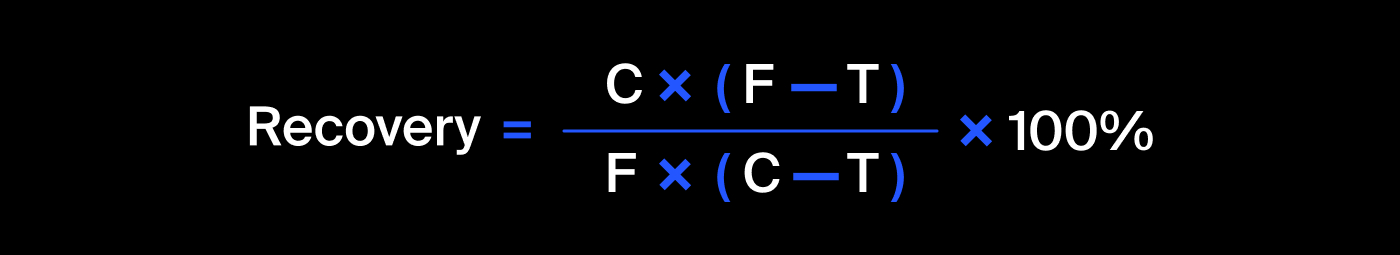

где:

C — доля золота в концентрате после флотации (очистки)

F — доля золота в сырье/концентрате до флотации (очистки)

T — доля золота в отвальных хвостах после флотации (очистки)

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`, затем найдем MAE между нашим расчетом и уже посчитанным признаком.